# Bayesian Neural Networks

Neural networks are powerful approximators. However, standard approaches for learning this approximators does not take into account the inherent uncertainty we may have when fitting a model. 

In [1]:
!pip install -q pyro-ppl torch
import numpy as np
import torch
from torch.distributions import constraints
import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Gamma, MultivariateNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.optim as optim

## Data

We use some fake data. As neural nets of even one hidden layer 
can be universal function approximators, we can see if we can 
train a simple neural network to fit a noisy sinusoidal data, like this:
    

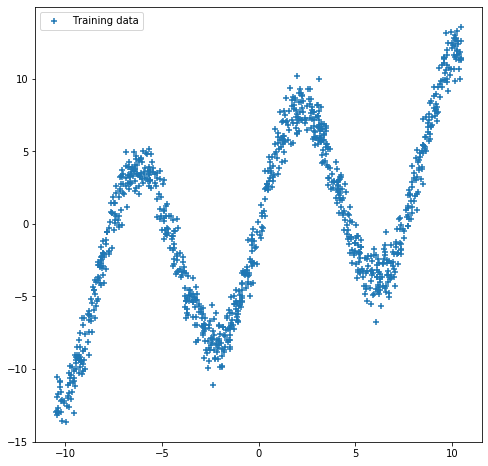

In [2]:
NSAMPLE = 1000
x_train = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_train = np.float32(np.random.normal(size=(NSAMPLE,1),scale=1.0))
y_train = np.float32(np.sin(0.75*x_train)*7.0+x_train*0.5+r_train*1.0)

plt.figure(figsize=(8, 8))
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.legend()

## Training a neural network

We employ a simple feedforward network with 20 hidden units to try to fit the data. 


In [3]:
NHIDDEN = 20

class NeuralNetwork():
    def __init__(self,NHIDDEN):
        self.w = torch.nn.Parameter(torch.randn(1, NHIDDEN)*0.05)
        self.b = torch.nn.Parameter(torch.randn(1, NHIDDEN)*0.05)
        self.w_out = torch.nn.Parameter(torch.randn(NHIDDEN,1)*0.05)
        self.b_out = torch.nn.Parameter(torch.randn(1, 1)*0.05)


    def params(self):
        return {"b":self.b, "w": self.w, "b_out":self.b_out, "w_out": self.w_out}

    def predict(self, x_data):
        hidden_layer = torch.nn.Tanh()(torch.mm(x_data, self.w) + self.b)
        return torch.matmul(hidden_layer,self.w_out) + self.b_out

neuralNetwork = NeuralNetwork(NHIDDEN)

loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(neuralNetwork.params().values(), lr=0.01)
num_iterations = 1000

for j in range(num_iterations):
    # run the model forward on the data
    y_pred = neuralNetwork.predict(torch.tensor(x_train))
    # calculate the mse loss
    loss = loss_fn(y_pred, torch.tensor(y_train))
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    if (j + 1) % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

[iteration 0100] loss: 24766.0586
[iteration 0200] loss: 20550.6543
[iteration 0300] loss: 10588.0801
[iteration 0400] loss: 8888.4727
[iteration 0500] loss: 8400.8467
[iteration 0600] loss: 8154.2358
[iteration 0700] loss: 8026.1597
[iteration 0800] loss: 7957.4785
[iteration 0900] loss: 7916.1509
[iteration 1000] loss: 7866.4009


We see that the neural network can fit this sinusoidal data quite well, as expected. 

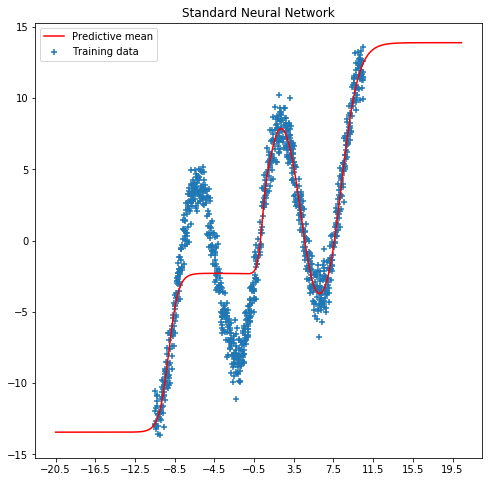

In [4]:
x_test = np.float32(np.arange(-20.5,20.5,0.1))
x_test = x_test.reshape(x_test.size,1)

y_test = neuralNetwork.predict(torch.tensor(x_test)).detach().numpy()

plt.figure(figsize=(8, 8))
plt.plot(x_test, y_test, 'r-', label='Predictive mean');
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.xticks(np.arange(-20.5, 20.5, 4))
plt.title('Standard Neural Network')
plt.legend();


However this model is unable to capture the uncertainty in the model. For example, when making predictions about a single point (e.g. around x=2.0) we can see we do not account aobut the inherent noise there is in this predictions. In next section, we will what happen when we introduce a Bayesian approach using [Edward2](https://github.com/tensorflow/probability/tree/master/tensorflow_probability/python/experimental/edward2). 

## Bayesian Learning of Neural Networks

[Bayesian modeling](http://mlg.eng.cam.ac.uk/zoubin/papers/NatureReprint15.pdf) offers a systematic framework for reasoning about model uncertainty. Instead of just learning point estimates, we're going to learn a distribution over variables that are consistent with the observed data.

In Bayesian learning, the weights of the network are `random variables`. The output of the nework is another `random variable`. And the random variable of the output is the one that implicitlyl defines the ``loss function``. So, when making Bayesian learning we do not define ``loss functions``, we do define ``random variables``. For more information you can check [this talk](https://www.cs.ox.ac.uk/people/yarin.gal/website/PDFs/2017_OReilly_talk.pdf) and this [paper](https://arxiv.org/abs/1908.03442).

In [Edward2](https://github.com/tensorflow/probability/tree/master/tensorflow_probability/python/experimental/edward2), we first define our model, where the weights of the neural network are defined as random variables. Second, the input `x` and output `y` are also define as random variables. More precisely, the output `y` is defined as a Gaussian random varible. The mean of the Gaussian is the output of the neural network. 

In [5]:
def model(NHIDDEN, x_train, y_train):
    W = pyro.sample("W", Normal(loc = torch.zeros([1,NHIDDEN]), scale=1.))
    b = pyro.sample("b", Normal(loc = torch.zeros([1,NHIDDEN]), scale=1.))

    W_out = pyro.sample("W_out", Normal(loc = torch.zeros([NHIDDEN,1]), scale=1.))
    b_out = pyro.sample("b_out", Normal(loc = torch.zeros([1,1]), scale=1.))

    hidden_layer = torch.nn.Tanh()(torch.mm(x_train, W) + b)
    out = torch.matmul(hidden_layer,W_out) + b_out
    y = pyro.sample("y", Normal(loc = out , scale= 1.0), obs=y_train) 

To perform Bayesian learning, we resort the scalable variational methods available in Edward2, which require the definition of a `q` model. For details,see the documentation about [Edward2](https://github.com/tensorflow/probability/tree/master/tensorflow_probability/python/experimental/edward2). For a deeper theoretical despcription, read this [paper](https://arxiv.org/abs/1908.03442).

In [6]:
def guide(NHIDDEN, x_train=None, y_train=None):

    W_loc = pyro.param("W_loc", torch.randn(1,NHIDDEN)*0.05)
    b_loc = pyro.param("b_loc",torch.randn(1,NHIDDEN)*0.05)
    W_scale = torch.nn.Softplus()(pyro.param("W_scale", torch.randn(1,NHIDDEN)*0.05 -10))+0.01
    b_scale = torch.nn.Softplus()(pyro.param("b_scale", torch.randn(1,NHIDDEN)*0.05 -10))


    qW = pyro.sample("W", Normal(W_loc, scale = W_scale))
    qb = pyro.sample("b", Normal(b_loc, scale = b_scale))


    W_out_loc = pyro.param("W_out_loc", torch.randn(NHIDDEN,1)*0.05)
    b_out_loc = pyro.param("b_out_loc",torch.randn(1,1)*0.05)
    W_out_scale = torch.nn.Softplus()(pyro.param("W_out_scale", torch.randn(NHIDDEN,1)*0.05 -10))
    b_out_scale = torch.nn.Softplus()(pyro.param("b_out_scale", torch.randn(1,1)*0.05 -10))

    qW_out = pyro.sample("W_out", Normal(W_out_loc, scale = W_out_scale))
    qb_out = pyro.sample("b_out", Normal(b_out_loc, scale = b_out_scale))

In [7]:
# setup the optimizer
adam_args = {"lr": 0.01}
optimizer = Adam(adam_args)

pyro.clear_param_store()
svi = SVI(model, guide, optimizer, loss=Trace_ELBO(), num_samples=10)
train_elbo = []
# training loop
for epoch in range(5000):
    loss = svi.step(NHIDDEN,torch.tensor(x_train), torch.tensor(y_train))
    train_elbo.append(-loss)
    if (epoch % 500) == 0:
        print("[epoch %03d] average training loss: %.4f" % (epoch, loss))

[epoch 000] average training loss: 20189.8744
[epoch 500] average training loss: 6338.0555
[epoch 1000] average training loss: 6258.0297
[epoch 1500] average training loss: 2587.0634
[epoch 2000] average training loss: 1942.6668
[epoch 2500] average training loss: 1896.4905
[epoch 3000] average training loss: 1835.0705
[epoch 3500] average training loss: 1911.2488
[epoch 4000] average training loss: 1846.0224
[epoch 4500] average training loss: 1810.7800


As can be seen in the nex figure, the output of our model is not deterministic. So, we can caputure the uncertainty in the data. See for example what happens now with the predictions at the point `x=2.0`. See also what happens with the uncertainty in out-of-range predictions.

In [8]:
def predictor(x_test):
    W_loc = pyro.param("W_loc")
    b_loc = pyro.param("b_loc")
    W_scale = torch.nn.Softplus()(pyro.param("W_scale"))+0.01
    b_scale = torch.nn.Softplus()(pyro.param("b_scale"))


    qW = pyro.sample("W", Normal(W_loc, scale = W_scale))
    qb = pyro.sample("b", Normal(b_loc, scale = b_scale))


    W_out_loc = pyro.param("W_out_loc")
    b_out_loc = pyro.param("b_out_loc")
    W_out_scale = torch.nn.Softplus()(pyro.param("W_out_scale"))
    b_out_scale = torch.nn.Softplus()(pyro.param("b_out_scale"))

    qW_out = pyro.sample("W_out", Normal(W_out_loc, scale = W_out_scale))
    qb_out = pyro.sample("b_out", Normal(b_out_loc, scale = b_out_scale))

    hidden_layer = torch.nn.Tanh()(torch.mm(x_test, qW) + qb)
    out = torch.matmul(hidden_layer,qW_out) + qb_out
    return pyro.sample("y", Normal(loc = out , scale= 1.0)) 


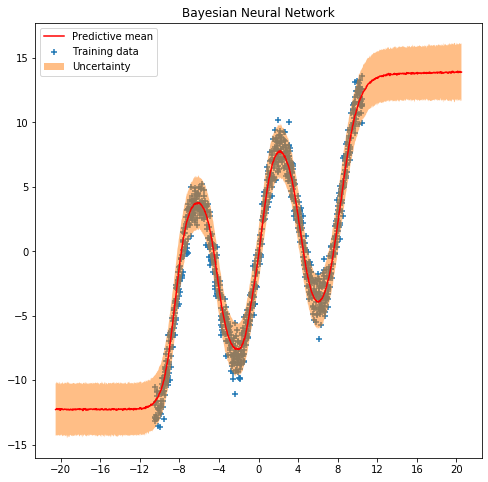

In [9]:
x_test = np.float32(np.linspace(-20.5, 20.5, NSAMPLE).reshape(-1, 1))

plt.figure(figsize=(8, 8))
y_pred_list = []
for i in range(1000):
    y_pred_list.append(predictor(torch.tensor(x_test)).detach().numpy())

y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.plot(x_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.fill_between(x_test.ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Uncertainty')
plt.xticks(np.arange(-20., 20.5, 4))
plt.title('Bayesian Neural Network')
plt.legend();

### <span style="color:red">Exercise: </span>  Model the Variance

In the above model, the variance of the variable ``y`` was assumed fixed:

1. Introduce a Pyro parameter to learn the variance. Hint: Initialize with a very small value. 

2. Introduce a Pryro random variable to learn the variance. Hint: Initialize the guide's random variable with a very small value.

3. Make the variance dependent of the input data

Evaluate the output in each cases and compare with the previous resutls. 
